 Part 1: Baseline Inference

Show the limitations of the pre-trained model on D2
Load a sample patient: T2 image + gland mask
Preprocess to match MONAI model requirements
Load MONAI’s pre-trained model.pt
Run inference on a few patients
Visualize & optionally compute Dice score
Brief comment on performance / batch effects

In [2]:
import os
import nibabel as nib
import numpy as np
import torch
import matplotlib.pyplot as plt
from monai.transforms import (
    LoadImage,
    Compose,
    EnsureChannelFirst,
    Resize,
    ScaleIntensity,
    ToTensor
)

from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference


In [4]:
import pandas as pd

cohort_path = "../data/PI-CAI/cohort.csv"
df = pd.read_csv(cohort_path)

# Pick a patient row (e.g., first row)
sample = df.iloc[0]
patient_id = str(sample["patientID"])
t2_path = os.path.join("../data/PI-CAI/file_data", sample["T2W_NIFTI"])
gland_path = os.path.join("../data/PI-CAI/file_data", sample["Gland_NIFTI"])

print("Patient:", patient_id)
print("T2 path:", t2_path)
print("Gland path:", gland_path)


Patient: 11284
T2 path: ../data/PI-CAI/file_data/11284/11284_t2w.nii.gz
Gland path: ../data/PI-CAI/file_data/11284/11284_gland.nii.gz


In [9]:
from monai.bundle import ConfigParser
from monai.networks.nets import UNet

# Path to the MONAI bundle config
config_file = "../models/prostate_mri_anatomy/configs/inference.json"

# Parse the config
parser = ConfigParser()
parser.read_config(config_file)

# Load model architecture
model = parser.get_parsed_content("network_def")
model.load_state_dict(torch.load(
    "../models/prostate_mri_anatomy/models/model.pt",
    map_location=torch.device("cpu")
))
model.to("cpu")
model.eval()


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.15, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.15, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, t

In [14]:
# Data paths
cohort_path = "../data/PI-CAI/cohort.csv"
file_data_root = "../data/PI-CAI/file_data"

# Preprocessing pipeline
preprocess = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize((96, 96, 96)),
    ScaleIntensity(),
    ToTensor()
])

# Device (CPU assumed here)
device = torch.device("cpu")


In [15]:
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference

In [16]:
dice_metric = DiceMetric(include_background=False, reduction="none")
dice_scores = []


In [23]:
from tqdm import tqdm

df = pd.read_csv(cohort_path)
dice_scores = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    patient_id = row["patientID"]
    print(f"\n🧪 Processing patient: {patient_id}")

    try:
        # File paths
        t2_path = os.path.join(file_data_root, row["T2W_NIFTI"])
        gland_path = os.path.join(file_data_root, row["Gland_NIFTI"])

        # Preprocess
        t2_tensor = preprocess(t2_path).unsqueeze(0).to(device)        # [1, 1, D, H, W]
        gland_tensor = preprocess(gland_path).unsqueeze(0).to(device)  # [1, 1, D, H, W]

        # Inference
        with torch.no_grad():
            pred = sliding_window_inference(
                inputs=t2_tensor,
                roi_size=(96, 96, 96),
                sw_batch_size=1,
                predictor=model
            )
            pred_bin = (pred > 0.5).float()

        # Dice score
        dice_tensor = dice_metric(y_pred=pred_bin, y=gland_tensor)
        dice_tensor = dice_tensor[~torch.isnan(dice_tensor)]

        if dice_tensor.numel() == 0:
            print(f"⚠️  All Dice values are NaN for patient {patient_id}. Skipping.")
            continue

        score = dice_tensor.mean().item()
        dice_scores.append((patient_id, score))
        print(f"✅ Dice Score: {score:.4f}")

    except Exception as e:
        print(f"❌ Error processing patient {patient_id}: {e}")


  0%|          | 0/80 [00:00<?, ?it/s]


🧪 Processing patient: 11284


  1%|▏         | 1/80 [00:00<00:58,  1.34it/s]

✅ Dice Score: 0.0214

🧪 Processing patient: 10372


  2%|▎         | 2/80 [00:01<00:58,  1.33it/s]

✅ Dice Score: 0.0094

🧪 Processing patient: 10768


  4%|▍         | 3/80 [00:02<00:53,  1.43it/s]

✅ Dice Score: 0.0033

🧪 Processing patient: 10074


  5%|▌         | 4/80 [00:02<00:50,  1.51it/s]

✅ Dice Score: 0.0048

🧪 Processing patient: 10418


  6%|▋         | 5/80 [00:03<00:48,  1.55it/s]

✅ Dice Score: 0.0680

🧪 Processing patient: 11165


  8%|▊         | 6/80 [00:03<00:47,  1.57it/s]

✅ Dice Score: 0.0264

🧪 Processing patient: 10442


  9%|▉         | 7/80 [00:04<00:45,  1.60it/s]

✅ Dice Score: 0.0030

🧪 Processing patient: 10486


 10%|█         | 8/80 [00:05<00:45,  1.59it/s]

✅ Dice Score: 0.0135

🧪 Processing patient: 10043


 11%|█▏        | 9/80 [00:05<00:43,  1.62it/s]

✅ Dice Score: 0.0339

🧪 Processing patient: 10164


 12%|█▎        | 10/80 [00:06<00:42,  1.64it/s]

✅ Dice Score: 0.0040

🧪 Processing patient: 10241


 14%|█▍        | 11/80 [00:07<00:42,  1.64it/s]

✅ Dice Score: 0.0682

🧪 Processing patient: 10522


 15%|█▌        | 12/80 [00:07<00:41,  1.65it/s]

✅ Dice Score: 0.0078

🧪 Processing patient: 10728


 16%|█▋        | 13/80 [00:08<00:40,  1.67it/s]

✅ Dice Score: 0.0054

🧪 Processing patient: 10825


 18%|█▊        | 14/80 [00:08<00:41,  1.60it/s]

✅ Dice Score: 0.0554

🧪 Processing patient: 11137


 19%|█▉        | 15/80 [00:09<00:41,  1.58it/s]

✅ Dice Score: 0.0694

🧪 Processing patient: 11236


 20%|██        | 16/80 [00:10<00:39,  1.62it/s]

✅ Dice Score: 0.0034

🧪 Processing patient: 11361


 21%|██▏       | 17/80 [00:10<00:38,  1.64it/s]

✅ Dice Score: 0.0137

🧪 Processing patient: 10107


 22%|██▎       | 18/80 [00:11<00:37,  1.64it/s]

✅ Dice Score: 0.0324

🧪 Processing patient: 10539


 24%|██▍       | 19/80 [00:11<00:37,  1.64it/s]

✅ Dice Score: 0.0510

🧪 Processing patient: 10743


 25%|██▌       | 20/80 [00:12<00:36,  1.65it/s]

✅ Dice Score: 0.0043

🧪 Processing patient: 10910


 26%|██▋       | 21/80 [00:13<00:36,  1.63it/s]

✅ Dice Score: 0.0080

🧪 Processing patient: 11051


 28%|██▊       | 22/80 [00:13<00:35,  1.62it/s]

✅ Dice Score: 0.0248

🧪 Processing patient: 11086


 29%|██▉       | 23/80 [00:14<00:35,  1.62it/s]

✅ Dice Score: 0.0250

🧪 Processing patient: 11155


 30%|███       | 24/80 [00:14<00:34,  1.63it/s]

✅ Dice Score: 0.0287

🧪 Processing patient: 11444


 31%|███▏      | 25/80 [00:15<00:33,  1.63it/s]

✅ Dice Score: 0.0265

🧪 Processing patient: 10005


 32%|███▎      | 26/80 [00:16<00:32,  1.64it/s]

✅ Dice Score: 0.0492

🧪 Processing patient: 10329


 34%|███▍      | 27/80 [00:16<00:32,  1.65it/s]

✅ Dice Score: 0.0368

🧪 Processing patient: 10434


 35%|███▌      | 28/80 [00:17<00:31,  1.65it/s]

✅ Dice Score: 0.0370

🧪 Processing patient: 10484


 36%|███▋      | 29/80 [00:18<00:31,  1.62it/s]

✅ Dice Score: 0.0752

🧪 Processing patient: 10807


 38%|███▊      | 30/80 [00:18<00:30,  1.64it/s]

✅ Dice Score: 0.0092

🧪 Processing patient: 10888


 39%|███▉      | 31/80 [00:19<00:30,  1.62it/s]

✅ Dice Score: 0.0138

🧪 Processing patient: 11177


 40%|████      | 32/80 [00:19<00:29,  1.64it/s]

✅ Dice Score: 0.0056

🧪 Processing patient: 11253


 41%|████▏     | 33/80 [00:20<00:28,  1.63it/s]

✅ Dice Score: 0.0582

🧪 Processing patient: 11300


 42%|████▎     | 34/80 [00:21<00:29,  1.57it/s]

✅ Dice Score: 0.0258

🧪 Processing patient: 10085


 44%|████▍     | 35/80 [00:21<00:28,  1.60it/s]

✅ Dice Score: 0.0063

🧪 Processing patient: 10274


 45%|████▌     | 36/80 [00:22<00:27,  1.59it/s]

✅ Dice Score: 0.0051

🧪 Processing patient: 10380


 46%|████▋     | 37/80 [00:23<00:26,  1.62it/s]

✅ Dice Score: 0.0390

🧪 Processing patient: 10390


 48%|████▊     | 38/80 [00:23<00:25,  1.65it/s]

✅ Dice Score: 0.0044

🧪 Processing patient: 10665


 49%|████▉     | 39/80 [00:24<00:25,  1.63it/s]

✅ Dice Score: 0.0495

🧪 Processing patient: 10872


 50%|█████     | 40/80 [00:24<00:25,  1.60it/s]

✅ Dice Score: 0.0708

🧪 Processing patient: 11168


 51%|█████▏    | 41/80 [00:25<00:24,  1.61it/s]

✅ Dice Score: 0.0277

🧪 Processing patient: 10059


 52%|█████▎    | 42/80 [00:26<00:24,  1.58it/s]

✅ Dice Score: 0.0647

🧪 Processing patient: 10262


 54%|█████▍    | 43/80 [00:26<00:24,  1.49it/s]

✅ Dice Score: 0.0469

🧪 Processing patient: 10322


 55%|█████▌    | 44/80 [00:27<00:23,  1.54it/s]

✅ Dice Score: 0.0393

🧪 Processing patient: 10340


 56%|█████▋    | 45/80 [00:28<00:22,  1.59it/s]

✅ Dice Score: 0.0243

🧪 Processing patient: 10607


 57%|█████▊    | 46/80 [00:28<00:21,  1.61it/s]

✅ Dice Score: 0.0185

🧪 Processing patient: 10798


 59%|█████▉    | 47/80 [00:29<00:20,  1.64it/s]

✅ Dice Score: 0.0070

🧪 Processing patient: 10839


 60%|██████    | 48/80 [00:29<00:19,  1.65it/s]

✅ Dice Score: 0.0344

🧪 Processing patient: 10915


 61%|██████▏   | 49/80 [00:30<00:19,  1.62it/s]

✅ Dice Score: 0.0082

🧪 Processing patient: 11231


 62%|██████▎   | 50/80 [00:31<00:18,  1.65it/s]

✅ Dice Score: 0.0401

🧪 Processing patient: 11278


 64%|██████▍   | 51/80 [00:31<00:17,  1.66it/s]

✅ Dice Score: 0.0137

🧪 Processing patient: 10040


 65%|██████▌   | 52/80 [00:32<00:16,  1.67it/s]

✅ Dice Score: 0.0486

🧪 Processing patient: 10117


 66%|██████▋   | 53/80 [00:32<00:16,  1.67it/s]

✅ Dice Score: 0.0936

🧪 Processing patient: 10168


 68%|██████▊   | 54/80 [00:33<00:15,  1.69it/s]

✅ Dice Score: 0.0057

🧪 Processing patient: 10211


 69%|██████▉   | 55/80 [00:34<00:14,  1.69it/s]

✅ Dice Score: 0.0409

🧪 Processing patient: 10216


 70%|███████   | 56/80 [00:34<00:14,  1.68it/s]

✅ Dice Score: 0.0599

🧪 Processing patient: 10339


 71%|███████▏  | 57/80 [00:35<00:14,  1.63it/s]

✅ Dice Score: 0.0547

🧪 Processing patient: 10568


 72%|███████▎  | 58/80 [00:35<00:13,  1.64it/s]

✅ Dice Score: 0.0440

🧪 Processing patient: 10668


 74%|███████▍  | 59/80 [00:36<00:12,  1.67it/s]

✅ Dice Score: 0.0026

🧪 Processing patient: 10699


 75%|███████▌  | 60/80 [00:37<00:12,  1.66it/s]

✅ Dice Score: 0.0783

🧪 Processing patient: 11122


 76%|███████▋  | 61/80 [00:37<00:11,  1.66it/s]

✅ Dice Score: 0.0512

🧪 Processing patient: 11188


 78%|███████▊  | 62/80 [00:38<00:10,  1.67it/s]

✅ Dice Score: 0.0050

🧪 Processing patient: 11247


 79%|███████▉  | 63/80 [00:38<00:10,  1.68it/s]

✅ Dice Score: 0.0259

🧪 Processing patient: 11260


 80%|████████  | 64/80 [00:39<00:09,  1.61it/s]

✅ Dice Score: 0.0034

🧪 Processing patient: 11280


 81%|████████▏ | 65/80 [00:40<00:09,  1.64it/s]

✅ Dice Score: 0.0428

🧪 Processing patient: 10048


 82%|████████▎ | 66/80 [00:40<00:08,  1.60it/s]

✅ Dice Score: 0.0344

🧪 Processing patient: 10097


 84%|████████▍ | 67/80 [00:41<00:08,  1.59it/s]

✅ Dice Score: 0.0278

🧪 Processing patient: 10233


 85%|████████▌ | 68/80 [00:42<00:07,  1.62it/s]

✅ Dice Score: 0.0286

🧪 Processing patient: 10268


 86%|████████▋ | 69/80 [00:42<00:06,  1.63it/s]

✅ Dice Score: 0.0533

🧪 Processing patient: 10294


 88%|████████▊ | 70/80 [00:43<00:06,  1.64it/s]

✅ Dice Score: 0.0146

🧪 Processing patient: 10503


 89%|████████▉ | 71/80 [00:43<00:05,  1.62it/s]

✅ Dice Score: 0.0355

🧪 Processing patient: 10589


 90%|█████████ | 72/80 [00:44<00:04,  1.63it/s]

✅ Dice Score: 0.0059

🧪 Processing patient: 10804


 91%|█████████▏| 73/80 [00:45<00:04,  1.65it/s]

✅ Dice Score: 0.0389

🧪 Processing patient: 10968


 92%|█████████▎| 74/80 [00:45<00:03,  1.65it/s]

✅ Dice Score: 0.0911

🧪 Processing patient: 11229


 94%|█████████▍| 75/80 [00:46<00:03,  1.66it/s]

✅ Dice Score: 0.0450

🧪 Processing patient: 11384


 95%|█████████▌| 76/80 [00:46<00:02,  1.67it/s]

✅ Dice Score: 0.0398

🧪 Processing patient: 10157


 96%|█████████▋| 77/80 [00:47<00:01,  1.68it/s]

✅ Dice Score: 0.0347

🧪 Processing patient: 10383


 98%|█████████▊| 78/80 [00:48<00:01,  1.64it/s]

✅ Dice Score: 0.0502

🧪 Processing patient: 11256


 99%|█████████▉| 79/80 [00:48<00:00,  1.65it/s]

✅ Dice Score: 0.0587

🧪 Processing patient: 11448


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]

✅ Dice Score: 0.0414


In [24]:
import pandas as pd

results_df = pd.DataFrame(dice_scores, columns=["patientID", "dice_score"])
results_df.to_csv("d2_dice_scores.csv", index=False)
print("\n📊 Summary Stats:")
print(results_df.describe())



📊 Summary Stats:
          patientID  dice_score
count     80.000000   80.000000
mean   10678.087500    0.032230
std      441.159554    0.023187
min    10005.000000    0.002566
25%    10289.000000    0.008911
50%    10636.000000    0.030564
75%    11141.500000    0.048771
max    11448.000000    0.093583


In [25]:
# Load results
results_df = pd.read_csv("d2_dice_scores.csv")

# Sort by dice score ascending (worst first)
worst_cases = results_df.sort_values("dice_score").head(3)
print(worst_cases)


    patientID  dice_score
58      10668    0.002566
6       10442    0.003024
2       10768    0.003285


In [31]:
import os
import torch
import matplotlib.pyplot as plt
from monai.inferers import sliding_window_inference

def visualize_prediction(patient_id):
    # Paths
    t2_path = os.path.join(file_data_root, f"{patient_id}/{patient_id}_t2w.nii.gz")
    gland_path = os.path.join(file_data_root, f"{patient_id}/{patient_id}_gland.nii.gz")

    # Preprocess input & label
    t2_tensor = preprocess(t2_path).unsqueeze(0).to(device)        # [1, 1, D, H, W]
    gland_tensor = preprocess(gland_path).unsqueeze(0).to(device)  # [1, 1, D, H, W]

    # Run model inference
    with torch.no_grad():
        pred = sliding_window_inference(
            inputs=t2_tensor,
            roi_size=(96, 96, 96),
            sw_batch_size=1,
            predictor=model
        )
        pred_bin = (pred > 0.5).float().cpu()  # [1, 1, D, H, W]

    # Safely extract numpy volumes
    t2_np = t2_tensor[0, 0].cpu().numpy()       # [D, H, W]
    gland_np = gland_tensor[0, 0].cpu().numpy()
    pred_np = pred_bin[0, 0].numpy()

    # Select middle slice from axial plane
    slice_idx = t2_np.shape[0] // 2

    # Plot slices
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(t2_np[slice_idx], cmap="gray")
    plt.title("T2 Image")

    plt.subplot(1, 3, 2)
    plt.imshow(gland_np[slice_idx], cmap="Reds")
    plt.title("Ground Truth Gland")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_np[slice_idx], cmap="Blues")
    plt.title("Predicted Gland")

    plt.suptitle(f"Patient {patient_id}")
    plt.show()


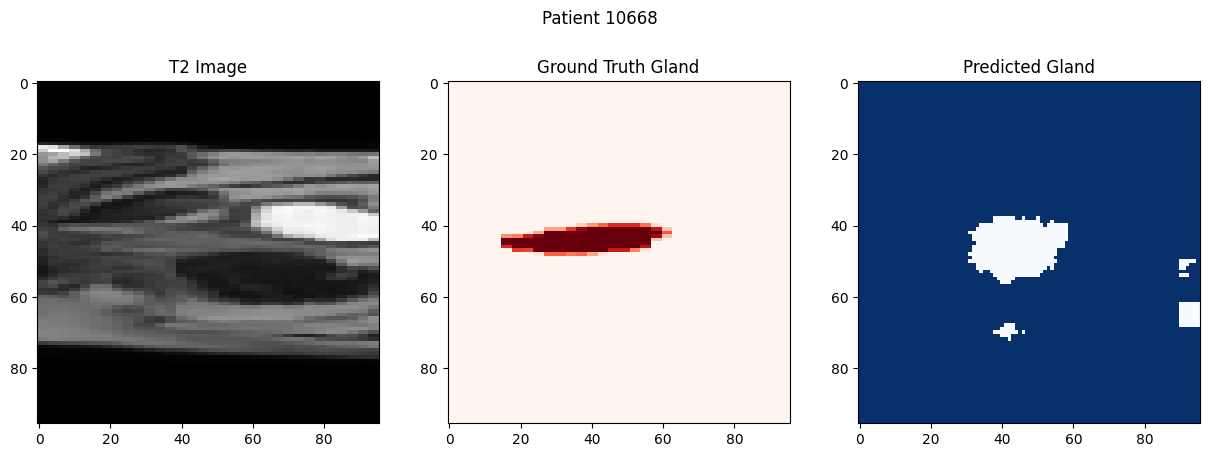

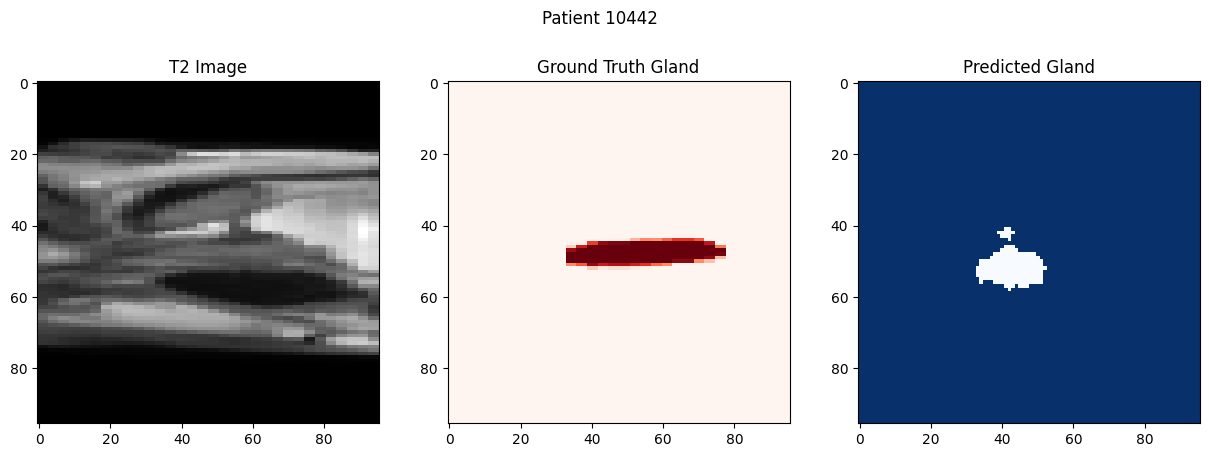

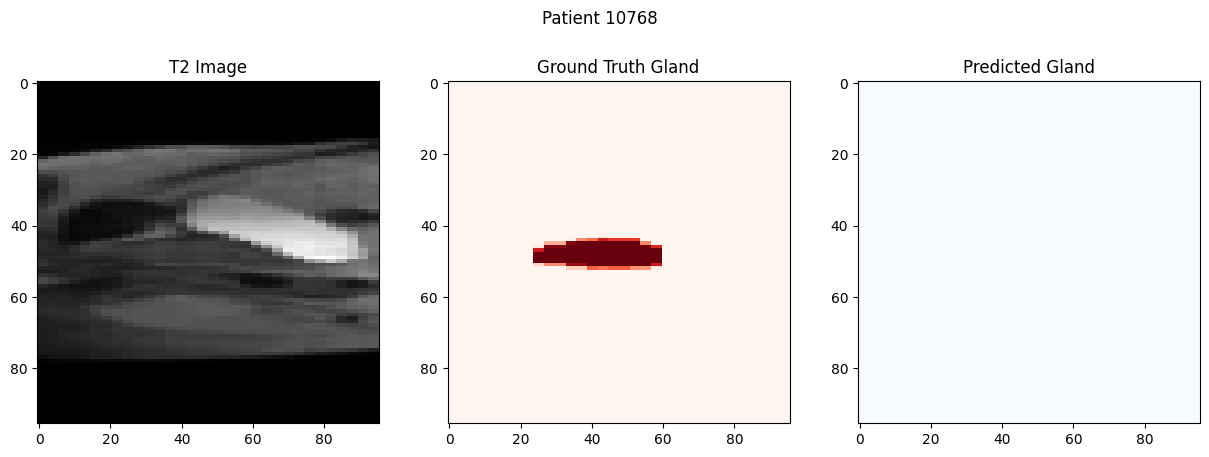

In [32]:
for patient_id in worst_cases["patientID"]:
    visualize_prediction(patient_id)
